In [2]:
import torch
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader


In [21]:
transform_train=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
    std=(0.2470, 0.2435, 0.2616))
])
transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
    std=(0.2470, 0.2435, 0.2616))
])
training_set=torchvision.datasets.CIFAR10(
    root='/home/sachchida/gitrepo/Deeplearning/data/cifar10',train=True,download=True,transform=transform_train
)
testing_set=torchvision.datasets.CIFAR10(
    root='/home/sachchida/gitrepo/Deeplearning/data/cifar10',train=False,download=True,transform=transform_test
)

#### transforms.RandomHorizontalFlip(p=0.5)
Randomly flips an image left ↔ right
Probability = 0.5 (default)
Example:
A car, ship, animal → still valid after flip
Purpose:
Teach the model invariance to orientation
Prevent overfitting to exact pixel positions

#### transforms.RandomCrop(32, padding=4)
Add 4-pixel padding on all sides → image becomes 40×40
Randomly crop a 32×32 region
Purpose:
Simulates small translations
Makes the model robust to object position shifts

Why are these NOT used in transform_test?
Goal: Learn general patterns
→ randomness is GOOD
Goal: Measure true performance
→ randomness is BAD

In [22]:
training_loader=DataLoader(training_set,batch_size=128,shuffle=True,num_workers=4)
testing_loader=DataLoader(testing_set,batch_size=128,shuffle=True,num_workers=4)

input image size 3 × 32 × 32 (channel*H*W) <br>
first convolution Output size = (W − K + 2P) / S + 1 <br>
(32 − 3 + 2×1) / 1 + 1 = 32<br>
max_pooling self.pool = nn.MaxPool2d(2, 2)<br>
32 × 32 → 16 × 16 ---> after pool 32 × 16 × 16<br>
second convolution<br>
self.conv2 = nn.Conv2d(32, 64, 3, padding=1)<br>
16 × 16 → 16 × 16 --> output 64 × 16 × 16 <br>
second pool 16 × 16 → 8 × 8<br>
final feature_map 64 × 8 × 8 (hence fc1-64 × 8 × 8)<br>
self.fc1 = nn.Linear(64 * 8 * 8, 256) <br>
Input features = 4096<br>
Hidden neurons = 256<br>
self.fc2=nn.Linear(256,10)<br>
hiddent_nueron=256 <br>
output neuron=10<br>


In [23]:
import torch.nn as nn
import torch.nn.functional as F

class CIFARCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1=nn.Conv2d(3,32,3,padding=1)
        self.conv2=nn.Conv2d(32,64,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.dropout=nn.Dropout(0.3)
        self.fc1=nn.Linear(64*8*8,256)
        self.fc2=nn.Linear(256,10)
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x))) ### conv1->relu->maxpool
        x=self.pool(F.relu(self.conv2(x))) ### conv2->relu->maxpool
        x = x.view(x.size(0), -1) ### flattening the feature map
        x=self.dropout(F.relu(self.fc1(x))) ### flattened->fc1->relu (dropout in hidden layer)
        x=self.fc2(x) ###  # logits (NO relu)
        return x
    
    ### Optional improvment could be 
#     self.bn1 = nn.BatchNorm2d(32)
# self.bn2 = nn.BatchNorm2d(64)
# x = self.pool(F.relu(self.bn1(self.conv1(x))))


### Training loop

In [24]:
import torch.optim as optim
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=CIFARCNN().to(device=device)
optimizer=optim.Adam(model.parameters(),lr=1e-3)

criterion=nn.CrossEntropyLoss()

def train(model,loader):
    model.train()
    total_loss=0
    for images,labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    return total_loss/len(loader)


In [25]:
def evaluate(model,loader):
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for images,labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs=model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [26]:
epochs = 30
for epoch in range(epochs):
    loss = train(model, training_loader)
    acc = evaluate(model, testing_loader)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Test Acc: {acc:.2f}%")

Epoch 1/30 | Loss: 1.6073 | Test Acc: 55.48%
Epoch 2/30 | Loss: 1.2769 | Test Acc: 62.33%
Epoch 3/30 | Loss: 1.1486 | Test Acc: 64.56%
Epoch 4/30 | Loss: 1.0654 | Test Acc: 68.50%
Epoch 5/30 | Loss: 1.0179 | Test Acc: 69.90%
Epoch 6/30 | Loss: 0.9706 | Test Acc: 71.81%
Epoch 7/30 | Loss: 0.9331 | Test Acc: 72.81%
Epoch 8/30 | Loss: 0.9116 | Test Acc: 73.22%
Epoch 9/30 | Loss: 0.8764 | Test Acc: 73.57%
Epoch 10/30 | Loss: 0.8659 | Test Acc: 74.81%
Epoch 11/30 | Loss: 0.8460 | Test Acc: 74.85%
Epoch 12/30 | Loss: 0.8258 | Test Acc: 75.56%
Epoch 13/30 | Loss: 0.8106 | Test Acc: 75.26%
Epoch 14/30 | Loss: 0.8012 | Test Acc: 75.97%
Epoch 15/30 | Loss: 0.7838 | Test Acc: 75.90%
Epoch 16/30 | Loss: 0.7804 | Test Acc: 76.24%
Epoch 17/30 | Loss: 0.7641 | Test Acc: 76.59%
Epoch 18/30 | Loss: 0.7540 | Test Acc: 77.34%
Epoch 19/30 | Loss: 0.7496 | Test Acc: 77.09%
Epoch 20/30 | Loss: 0.7418 | Test Acc: 77.05%
Epoch 21/30 | Loss: 0.7327 | Test Acc: 77.03%
Epoch 22/30 | Loss: 0.7281 | Test Acc: 77.9

In [27]:
import torch

def predict_image(model, image_tensor, device):
    """
    image_tensor: shape [3, 32, 32] (already transformed)
    """
    model.eval()

    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)  # add batch dim
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()



In [28]:
classes = (
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)


In [29]:
import matplotlib.pyplot as plt

def denormalize(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3,1,1)
    img = img * std + mean
    return img.clamp(0, 1)

In [30]:
import random

def show_predictions(model, dataset, device, n=5):
    model.eval()

    plt.figure(figsize=(12, 4))

    for i in range(n):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]

        pred = predict_image(model, image, device)

        image = denormalize(image)
        image = image.permute(1, 2, 0)  # CHW → HWC

        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.title(f"Pred: {classes[pred]}\nTrue: {classes[label]}")
        plt.axis("off")

    plt.show()


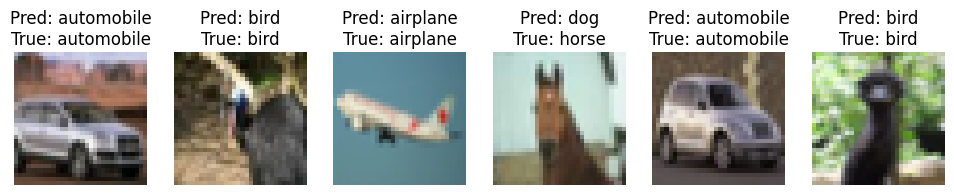

In [ ]:
show_predictions(model, testing_set, device, n=15)